In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import os
import relative_accuracy as ra
import geh as ga

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

C:\Users\esugom\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

## Input

#### 5 mins

In [8]:
# Train
Xt5 = Deep_train_5
yt5 = scaler.inverse_transform(Output_train_5)
# Test
Xv5 = Deep_test_5
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [9]:
# Train
Xt15 = Deep_train_15
yt15 = scaler.inverse_transform(Output_train_15)
# Test
Xv15 = Deep_test_15
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [10]:
# Train
Xt30 = Deep_train_30
yt30 = scaler.inverse_transform(Output_train_30)
# Test
Xv30 = Deep_test_30
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [11]:
# Train
Xt60 = Deep_train_60
yt60 = scaler.inverse_transform(Output_train_60)
# Test
Xv60 = Deep_test_60
yv60 = scaler.inverse_transform(Output_test_60)

# LSTM Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# We're using 6 features in our time series samples (6 spatial locations)
n_features = 6
length = 15
# val_percent = 0.07567        # 2 weeks
val_percent = 0.2
batch_size = 32

In [14]:
input_shape = (length, n_features)

In [15]:
from tensorflow import keras

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# 5 mins ahead

In [16]:
def build_model_5(hp):
    # define model
    model_5 = Sequential()
    
    # Simple LSTM layer
    model_5.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_5.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_5.add(Dense(n_features))
    
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_5

In [17]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="6a-5"
)

In [18]:
tuner5.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [19]:
tuner5.search(Xt5, yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

Trial 30 Complete [00h 22m 05s]
val_loss: 453.4235076904297

Best val_loss So Far: 404.3006896972656
Total elapsed time: 08h 39m 29s
INFO:tensorflow:Oracle triggered exit


In [20]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\6a-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 91
Units_2: 45
learning_rate: 0.001
Score: 404.3006896972656


### Best Model

In [21]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [22]:
scaler_filename = "Best_HP/6a-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/6a-5']

In [23]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 91)            35672     
_________________________________________________________________
lstm_1 (LSTM)                (None, 45)                24660     
_________________________________________________________________
dense (Dense)                (None, 6)                 276       
Total params: 60,608
Trainable params: 60,608
Non-trainable params: 0
_________________________________________________________________


In [24]:
model5.fit(Xt5, yt5, 
           epochs = 100, 
           verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 22s 14ms/step - loss: 1619.4192 - mean_absolute_error: 25.6003 - root_mean_squared_error: 40.2420 - mean_absolute_percentage_error: 40.7189
Epoch 2/100
1539/1539 [==============================] - 22s 15ms/step - loss: 657.3209 - mean_absolute_error: 18.2033 - root_mean_squared_error: 25.6383 - mean_absolute_percentage_error: 26.0192
Epoch 3/100
1539/1539 [==============================] - 23s 15ms/step - loss: 582.8234 - mean_absolute_error: 17.1470 - root_mean_squared_error: 24.1417 - mean_absolute_percentage_error: 24.8493
Epoch 4/100
1539/1539 [==============================] - 22s 14ms/step - loss: 565.5579 - mean_absolute_error: 16.8430 - root_mean_squared_error: 23.7815 - mean_absolute_percentage_error: 24.3318
Epoch 5/100
1539/1539 [==============================] - 22s 14ms/step - loss: 531.8369 - mean_absolute_error: 16.2982 - root_mean_squared_error: 23.0616 - mean_absolute_percentage_error: 23.6078
Epoch 6/100
1539/15

1539/1539 [==============================] - 21s 14ms/step - loss: 359.4111 - mean_absolute_error: 13.2105 - root_mean_squared_error: 18.9581 - mean_absolute_percentage_error: 17.5937
Epoch 84/100
1539/1539 [==============================] - 21s 14ms/step - loss: 358.7115 - mean_absolute_error: 13.2114 - root_mean_squared_error: 18.9397 - mean_absolute_percentage_error: 17.6077
Epoch 85/100
1539/1539 [==============================] - 22s 14ms/step - loss: 358.3405 - mean_absolute_error: 13.2041 - root_mean_squared_error: 18.9299 - mean_absolute_percentage_error: 17.6935
Epoch 86/100
1539/1539 [==============================] - 22s 14ms/step - loss: 359.0842 - mean_absolute_error: 13.2042 - root_mean_squared_error: 18.9495 - mean_absolute_percentage_error: 17.6102
Epoch 87/100
1539/1539 [==============================] - 22s 14ms/step - loss: 356.4900 - mean_absolute_error: 13.1647 - root_mean_squared_error: 18.8809 - mean_absolute_percentage_error: 17.6551
Epoch 88/100
1539/1539 [====

In [25]:
model5.save("my_dir/6a-5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_dir/6a-5\assets


In [26]:
metrics5 = pd.DataFrame(model5.history.history)

<AxesSubplot:>

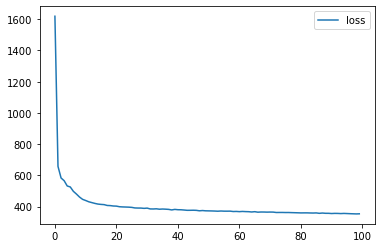

In [27]:
metrics5[['loss']].plot()

In [28]:
# model5 = keras.models.load_model("my_dir/6a-5")

In [30]:
# RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
# RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
# RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

# res5 = [RA10, RA15, RA20]
# print(res5)

In [31]:
# # Create Figure (empty canvas)
# fig = plt.figure(figsize=(18,6))

# # Add set of axes to figure
# axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# # Plot on that set of axes
# axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
# axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
# axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

# #axes.set_xlim(0,24)
# axes.set_ylim(-170,600)
# axes.set_xlabel('Time (h)')
# axes.set_ylabel('Flow (veh/5-Min)')

# axes.legend(loc=1)
# axes.grid()

# axes.set_xticks([144 + i for i in range(0, 4032, 288)])
# axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

# plt.show()

In [32]:
# # Create Figure (empty canvas)
# fig = plt.figure(figsize=(18,6))

# # Add set of axes to figure
# axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# # Plot on that set of axes
# axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
# axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
# axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

# axes.set_xlim(0,300)
# axes.set_ylim(-170,600)
# axes.set_xlabel('Time (h)')
# axes.set_ylabel('Flow (veh/5-Min)')

# axes.legend(loc=1)
# axes.grid()

# axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
# axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

# plt.show()

# 15 mins ahead

In [33]:
def build_model_15(hp):
    # define model
    model_15 = Sequential()
    
    # 2 layer LSTM
    model_15.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_15.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_15.add(Dense(n_features))
    
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_15

In [34]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="6a-15"
)

In [35]:
tuner15.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [36]:
tuner15.search(Xt15, yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

Trial 30 Complete [00h 17m 50s]
val_loss: 523.2871398925781

Best val_loss So Far: 483.07928466796875
Total elapsed time: 07h 27m 49s
INFO:tensorflow:Oracle triggered exit


In [37]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\6a-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 35
Units_2: 46
learning_rate: 0.001
Score: 483.07928466796875


### Best Model

In [38]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [39]:
scaler_filename = "Best_HP/6a-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/6a-15']

In [40]:
model15.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 35)            5880      
_________________________________________________________________
lstm_1 (LSTM)                (None, 46)                15088     
_________________________________________________________________
dense (Dense)                (None, 6)                 282       
Total params: 21,250
Trainable params: 21,250
Non-trainable params: 0
_________________________________________________________________


In [41]:
model15.fit(Xt15, yt15, 
            epochs = 100,
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 18s 12ms/step - loss: 2043.3485 - mean_absolute_error: 29.2424 - root_mean_squared_error: 45.2034 - mean_absolute_percentage_error: 46.8579
Epoch 2/100
1539/1539 [==============================] - 18s 12ms/step - loss: 764.2783 - mean_absolute_error: 19.6643 - root_mean_squared_error: 27.6456 - mean_absolute_percentage_error: 28.1217
Epoch 3/100
1539/1539 [==============================] - 17s 11ms/step - loss: 684.9573 - mean_absolute_error: 18.6212 - root_mean_squared_error: 26.1717 - mean_absolute_percentage_error: 26.6155
Epoch 4/100
1539/1539 [==============================] - 17s 11ms/step - loss: 643.6826 - mean_absolute_error: 18.0092 - root_mean_squared_error: 25.3709 - mean_absolute_percentage_error: 25.8670
Epoch 5/100
1539/1539 [==============================] - 17s 11ms/step - loss: 622.7924 - mean_absolute_error: 17.6788 - root_mean_squared_error: 24.9558 - mean_absolute_percentage_error: 25.4022
Epoch 6/100
1539/15

1539/1539 [==============================] - 17s 11ms/step - loss: 441.9499 - mean_absolute_error: 14.6465 - root_mean_squared_error: 21.0226 - mean_absolute_percentage_error: 20.4037
Epoch 84/100
1539/1539 [==============================] - 17s 11ms/step - loss: 440.6835 - mean_absolute_error: 14.6190 - root_mean_squared_error: 20.9925 - mean_absolute_percentage_error: 20.4407
Epoch 85/100
1539/1539 [==============================] - 17s 11ms/step - loss: 442.3715 - mean_absolute_error: 14.6427 - root_mean_squared_error: 21.0326 - mean_absolute_percentage_error: 20.3802
Epoch 86/100
1539/1539 [==============================] - 17s 11ms/step - loss: 439.8919 - mean_absolute_error: 14.5962 - root_mean_squared_error: 20.9736 - mean_absolute_percentage_error: 20.4288
Epoch 87/100
1539/1539 [==============================] - 17s 11ms/step - loss: 442.3553 - mean_absolute_error: 14.6460 - root_mean_squared_error: 21.0322 - mean_absolute_percentage_error: 20.4176
Epoch 88/100
1539/1539 [====

In [42]:
model15.save("my_dir/6a-15")

INFO:tensorflow:Assets written to: my_dir/6a-15\assets


In [43]:
metrics15 = pd.DataFrame(model15.history.history)

<AxesSubplot:>

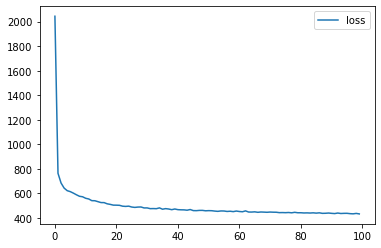

In [44]:
metrics15[['loss']].plot()

In [45]:
# model15 = keras.models.load_model("my_dir/6a-15")

In [48]:
# # Create Figure (empty canvas)
# fig = plt.figure(figsize=(18,6))

# # Add set of axes to figure
# axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# # Plot on that set of axes
# axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
# axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
# axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

# #axes.set_xlim(0,24)
# axes.set_ylim(-170,600)
# axes.set_xlabel('Time (h)')
# axes.set_ylabel('Flow (veh/5-Min)')

# axes.legend(loc=1)
# axes.grid()

# axes.set_xticks([144 + i for i in range(0, 4032, 288)])
# axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

# plt.show()

In [49]:
# # Create Figure (empty canvas)
# fig = plt.figure(figsize=(18,6))

# # Add set of axes to figure
# axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# # Plot on that set of axes
# axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
# axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
# axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

# axes.set_xlim(0,300)
# axes.set_ylim(-170,600)
# axes.set_xlabel('Time (h)')
# axes.set_ylabel('Flow (veh/5-Min)')

# axes.legend(loc=1)
# axes.grid()

# axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
# axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

# plt.show()

# 30 mins ahead

In [50]:
def build_model_30(hp):
    # define model
    model_30 = Sequential()
    
    # 2 layer LSTM
    model_30.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_30.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_30.add(Dense(n_features))
    
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_30

In [51]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="6a-30",
)

In [52]:
tuner30.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [53]:
tuner30.search(Xt30, yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 30 Complete [00h 10m 25s]
val_loss: 591.4913330078125

Best val_loss So Far: 547.3248596191406
Total elapsed time: 07h 41m 28s
INFO:tensorflow:Oracle triggered exit


In [54]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\6a-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 79
Units_2: 67
learning_rate: 0.001
Score: 547.3248596191406


### Best Model

In [55]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [56]:
scaler_filename = "Best_HP/6a-30"
joblib.dump(best_hp30, scaler_filename) 

['Best_HP/6a-30']

In [57]:
model30.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 79)            27176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 67)                39396     
_________________________________________________________________
dense (Dense)                (None, 6)                 408       
Total params: 66,980
Trainable params: 66,980
Non-trainable params: 0
_________________________________________________________________


In [58]:
model30.fit(Xt30, yt30, 
            epochs = 100,
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 25s 16ms/step - loss: 1965.3295 - mean_absolute_error: 29.1318 - root_mean_squared_error: 44.3320 - mean_absolute_percentage_error: 46.1099
Epoch 2/100
1539/1539 [==============================] - 25s 16ms/step - loss: 847.5756 - mean_absolute_error: 20.7679 - root_mean_squared_error: 29.1132 - mean_absolute_percentage_error: 30.1631
Epoch 3/100
1539/1539 [==============================] - 24s 16ms/step - loss: 768.7493 - mean_absolute_error: 19.6517 - root_mean_squared_error: 27.7263 - mean_absolute_percentage_error: 28.3117
Epoch 4/100
1539/1539 [==============================] - 24s 16ms/step - loss: 726.2488 - mean_absolute_error: 19.0476 - root_mean_squared_error: 26.9490 - mean_absolute_percentage_error: 27.3301
Epoch 5/100
1539/1539 [==============================] - 24s 16ms/step - loss: 703.4805 - mean_absolute_error: 18.7338 - root_mean_squared_error: 26.5232 - mean_absolute_percentage_error: 26.8786
Epoch 6/100
1539/15

1539/1539 [==============================] - 23s 15ms/step - loss: 458.5424 - mean_absolute_error: 14.9447 - root_mean_squared_error: 21.4136 - mean_absolute_percentage_error: 20.6155
Epoch 84/100
1539/1539 [==============================] - 24s 16ms/step - loss: 458.0013 - mean_absolute_error: 14.9353 - root_mean_squared_error: 21.4010 - mean_absolute_percentage_error: 20.5641
Epoch 85/100
1539/1539 [==============================] - 23s 15ms/step - loss: 457.5932 - mean_absolute_error: 14.9240 - root_mean_squared_error: 21.3914 - mean_absolute_percentage_error: 20.5793
Epoch 86/100
1539/1539 [==============================] - 23s 15ms/step - loss: 456.7925 - mean_absolute_error: 14.9069 - root_mean_squared_error: 21.3727 - mean_absolute_percentage_error: 20.4582
Epoch 87/100
1539/1539 [==============================] - 24s 16ms/step - loss: 455.8694 - mean_absolute_error: 14.8967 - root_mean_squared_error: 21.3511 - mean_absolute_percentage_error: 20.5193
Epoch 88/100
1539/1539 [====

In [59]:
model30.save("my_dir/6a-30")

INFO:tensorflow:Assets written to: my_dir/6a-30\assets


In [60]:
metrics30 = pd.DataFrame(model30.history.history)

<AxesSubplot:>

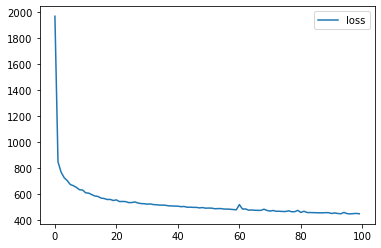

In [61]:
metrics30[['loss']].plot()

In [62]:
# model30 = keras.models.load_model("my_dir/6a-30")

# 60 mins ahead

In [67]:
def build_model_60(hp):
    # define model
    model_60 = Sequential()
    
    # 2 layer LSTM
    model_60.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_60.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_60.add(Dense(n_features))
    
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_60

In [68]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="6a-60",
)

In [69]:
tuner60.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [70]:
tuner60.search(Xt60, yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 30 Complete [00h 08m 55s]
val_loss: 750.0505676269531

Best val_loss So Far: 686.9244689941406
Total elapsed time: 07h 01m 47s
INFO:tensorflow:Oracle triggered exit


In [71]:
tuner60.results_summary(1)

Results summary
Results in C:\RunsOak\6a-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 23
Units_2: 94
learning_rate: 0.001
Score: 686.9244689941406


### Best Model

In [72]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [73]:
scaler_filename = "Best_HP/6a-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/6a-60']

In [74]:
model60.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 23)            2760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 94)                44368     
_________________________________________________________________
dense (Dense)                (None, 6)                 570       
Total params: 47,698
Trainable params: 47,698
Non-trainable params: 0
_________________________________________________________________


In [75]:
model60.fit(Xt60, yt60, 
            epochs = 100,
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 20s 13ms/step - loss: 2414.5105 - mean_absolute_error: 33.9456 - root_mean_squared_error: 49.1377 - mean_absolute_percentage_error: 56.8111
Epoch 2/100
1539/1539 [==============================] - 19s 13ms/step - loss: 1265.2626 - mean_absolute_error: 25.3049 - root_mean_squared_error: 35.5705 - mean_absolute_percentage_error: 36.0165
Epoch 3/100
1539/1539 [==============================] - 20s 13ms/step - loss: 1086.3002 - mean_absolute_error: 23.3627 - root_mean_squared_error: 32.9591 - mean_absolute_percentage_error: 32.4970
Epoch 4/100
1539/1539 [==============================] - 19s 12ms/step - loss: 1006.3794 - mean_absolute_error: 22.4713 - root_mean_squared_error: 31.7235 - mean_absolute_percentage_error: 31.7778
Epoch 5/100
1539/1539 [==============================] - 19s 12ms/step - loss: 954.6243 - mean_absolute_error: 21.8407 - root_mean_squared_error: 30.8970 - mean_absolute_percentage_error: 30.8491
Epoch 6/100
1539

1539/1539 [==============================] - 19s 12ms/step - loss: 563.8131 - mean_absolute_error: 16.5348 - root_mean_squared_error: 23.7448 - mean_absolute_percentage_error: 22.8360
Epoch 84/100
1539/1539 [==============================] - 19s 12ms/step - loss: 563.6140 - mean_absolute_error: 16.5379 - root_mean_squared_error: 23.7406 - mean_absolute_percentage_error: 22.8153
Epoch 85/100
1539/1539 [==============================] - 19s 13ms/step - loss: 564.7028 - mean_absolute_error: 16.5385 - root_mean_squared_error: 23.7635 - mean_absolute_percentage_error: 22.7777
Epoch 86/100
1539/1539 [==============================] - 19s 12ms/step - loss: 561.2717 - mean_absolute_error: 16.5089 - root_mean_squared_error: 23.6912 - mean_absolute_percentage_error: 22.7972
Epoch 87/100
1539/1539 [==============================] - 19s 12ms/step - loss: 560.5411 - mean_absolute_error: 16.4754 - root_mean_squared_error: 23.6758 - mean_absolute_percentage_error: 22.7608
Epoch 88/100
1539/1539 [====

In [76]:
model60.save("my_dir/6a-60")

INFO:tensorflow:Assets written to: my_dir/6a-60\assets


In [77]:
metrics60 = pd.DataFrame(model60.history.history)

<AxesSubplot:>

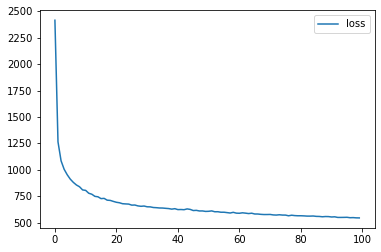

In [78]:
metrics60[['loss']].plot()

In [79]:
# model60 = keras.models.load_model("my_dir/6a-60")